<a href="https://colab.research.google.com/github/vtd9/space_regression/blob/indep_to_dep/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 2

Due 3/24/22

In [ ]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.utils.data as Data

In [ ]:
# Set plot parameters for entire notebook
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['font.size'] = 10

## 1.1 Data preprocessing

The CSV file should be in the same directory as this notebook. Otherwise, update the file_name path.

References:
* https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

### 1.1.1 Read CSV and define variable categories

In [ ]:
file_name = './Untitled spreadsheet - Terres_Li_Sample_Data_Set.csv'
df = pd.read_csv(file_name)

In [ ]:
# Independent variables
indep_vars = ['Bx', 'By', 'Bz', 'Bmag_avg', 'Ni_avg', 'Vx', 'Vy', 'Vz', 'VSW', 
'Vth_mag_Ion', 'Vth_para_Ion', 'Vth_perp_Ion', 'Ne', 'Ue', 'Te', 'Ti', 'Ti_para', 
'Ti_perp']

# Derived variables: from independent variables using formulas
deriv_vars = ['VA', 'Beta', 'Beta_para', 'Beta_perp', 'Omega_i', 'omega_pi', 
'omega_pe', 'rho_i', 'rho_s', 'rho_c', 'd_i', 'd_e', 'sigma_i', 'Lperp', 'lambda_d']

# Dependent variable: target
dep_var = ['k_brk']

# Check that the number of variables in each category are as expected
print('Independent: {}, derived: {}, dependent: {}'.format(
    len(indep_vars), len(deriv_vars), len(dep_var)))

# Convert Pandas dataframes to PyTorch tensors
indep = torch.tensor(df[indep_vars].values)
deriv = torch.tensor(df[deriv_vars].values)
dep = torch.tensor(df[dep_var].values)

Independent: 18, derived: 15, dependent: 1


### 1.1.2 Visualize the input data

In [ ]:
# Visualize the input data
def plot_many(xs, y, xs_names, num_cols=6, title='', size=(8, 7), fontsize=8):
    num_plots = len(xs_names)
    num_rows = int(num_plots / num_cols) + 1
    plt.subplots(figsize=size)
    plt.suptitle(title, fontsize=fontsize*1.5)

    # For each variable in x
    for i in range(num_plots):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.plot(xs[:, i], y, '.', alpha=0.5)
        plt.title(xs_names[i], fontsize=fontsize*1.2, y=1.1)
        plt.ticklabel_format(style='sci', scilimits=(-3, 4), axis='x')

    plt.tight_layout()

In [ ]:
#plot_many(indep, dep[:, 0], indep_vars, title='Raw data:\nIndependent variables vs. dependent variable (k_brk)')

In [ ]:
#plot_many(deriv, dep[:, 0], deriv_vars, title='Raw data:\nDerived variables vs. dependent variable (k_brk)')

### 1.1.3 Prepare for feeding into network

In [ ]:
# Normalize the input data
indep = torch.nn.functional.normalize(indep, dim=0)
deriv = torch.nn.functional.normalize(deriv, dim=0)

# Create datasets
indep_dep = Data.TensorDataset(indep, dep)
deriv_dep = Data.TensorDataset(deriv, dep)

# Decide on training, validation, and testing splits
train_size = int(0.8 * len(df))
valid_size = int(0.1 * len(df))
test_size = len(df) - (train_size + valid_size)
splits = [train_size, valid_size, test_size]

print('Training, validation, testing:', splits)

# Split the data for both indep-dep pairs & derived-dep pairs
train_indep, valid_indep, test_indep = Data.random_split(indep_dep, splits)
train_deriv, valid_deriv, test_deriv = Data.random_split(deriv_dep, splits)

Training, validation, testing: [5626, 703, 704]


In [ ]:
# Define dataloaders
batch_size = 64
train_loader_indep = Data.DataLoader(
    dataset=train_indep, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader_indep = Data.DataLoader(
    dataset=valid_indep, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_indep = Data.DataLoader(
    dataset=test_indep, batch_size=batch_size, shuffle=True, num_workers=2)

train_loader_deriv= Data.DataLoader(
    dataset=train_indep, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader_deriv = Data.DataLoader(
    dataset=valid_indep, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_deriv = Data.DataLoader(
    dataset=test_deriv, batch_size=batch_size, shuffle=True, num_workers=2)

## 1.2 Define classes and functions

References:
* https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

### 1.2.1 Network class

General neural network template to easily create models.

In [ ]:
class Net(nn.Module): 
    def __init__(self, num_in, hiddens, num_out,
        batch_norm=True, p_dropout=0.2):

        super(Net, self).__init__()
        layers = []
        
        # Define hidden layer(s)
        hiddens_list = [num_in, ] + list(hiddens)
        for i, hidden in enumerate(hiddens_list[:-1]):
            curr_hidden = [nn.Linear(hidden, hiddens_list[i+1]), nn.ReLU()]
        
            # If set, add batch normalization
            if batch_norm:
                curr_hidden.append(nn.BatchNorm1d(hiddens_list[i+1]))
            
            # If set, add dropout
            if p_dropout > 0:
                curr_hidden.append(nn.Dropout(p_dropout))

            layers += curr_hidden

        # Define output layer
        layers.append(nn.Linear(hiddens[-1], num_out))

        # Define entire stack
        self.stack = nn.Sequential(*layers)
        
    def forward(self, x):
        logits = self.stack(x)
        return logits

# Initialize parameters
def init_parameters(m):
    if isinstance(m, nn.Linear):
        # weights: Kaiming initialization
        nn.init.kaiming_normal_(m.weight)

        # biases: set to 0, as discussed in class
        m.bias.data.fill_(0.0) # Set bias to 0

### 1.2.2 Functions for training and testing

Train & test functions for one loop through the datasets (aka one epoch).

Epochs functions to loop over many epochs.

In [ ]:
def train_loop(loader, model, loss_fun, optimizer):
  '''
  Train a model for one epoch - i.e., one pass through the training data set.

  '''
  train_loss = 0.0

  # For each batch
  for X, y in loader:
      prediction = model(X) # forward pass
      loss = loss_fun(prediction, y) # compute loss
      train_loss += loss.item() # assume default reduction 'mean' over batch
      optimizer.zero_grad() # clear gradients for this loop
      loss.backward() # compute gradients
      optimizer.step() # apply gradients

  # Average loss in the epoch loop
  return train_loss/len(loader)
    
def test_loop(loader, model, loss_fun, return_y=False):
  '''
  Test a model through one pass through a validation/test data set.

  '''
  test_loss = 0.0

  # No backprop during validation/testing
  with torch.no_grad():
      for X, y in loader:
          prediction = model(X)
          test_loss += loss_fun(prediction, y).item()

  # If requested, return last prediction & the corresponding labels, too
  if return_y: 
    return prediction, y, test_loss/len(loader)
  else: # Else, return average loss in the loop
    return test_loss/len(loader)


def train_epochs(train_loader, valid_loader, model, loss_fun, optimizer, 
    epochs, verbose=False):
    '''
    Train and validate a model over multiple epochs.

    '''
    train_losses = np.empty(epochs)
    test_losses = np.empty(epochs)

    # For each epoch
    for epoch in range(epochs):
        train_losses[epoch] = train_loop(train_loader, model.double(), 
            loss_fun, optimizer)
        test_losses[epoch] = test_loop(valid_loader, model.double(), loss_fun)
    
        if verbose:
            print('epoch: {}\ttraining loss: {:.3e}'
            '\tvalidation loss: {:.3e}'.format(
                epoch, train_losses[epoch], test_losses[epoch]))
    
    return train_losses, test_losses

In [ ]:
def plot_mult_models(models, xlabel='Epoch', ylabel='Mean squared error', 
                     yscale='log', title='', train_index=0, valid_index=1,
                     result_key='result', train_append=' training', 
                     valid_append=' validation', train_style='-', 
                     valid_style='--', colors=('b', 'g', 'r', 'c', 'm', 'k')):
  '''
  Plot multiple models on the same graph, each with its own training and 
  validation results.
  
  '''
  for (key, value), color in zip(models.items(), colors):
      # Plot training performance
      plt.plot(np.arange(epochs), 
          value[result_key][train_index], color+train_style, label=key+train_append)
      
      # Plot validation performance
      plt.plot(np.arange(epochs), 
          value[result_key][valid_index], color+valid_style, label=key+valid_append)
  plt.title(title)
  plt.yscale(yscale)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()

## 1.3 Independent &rarr; dependent variables

Create a model to relate the independent variables to the dependent variable.

In [ ]:
# Standard mean squared error loss function
mse = nn.MSELoss(reduction='mean') # default reduction

# Create container to store models, optimizers, & results in
models = {}

### 1.3.1. Models with 3 hidden layers

`model16`: 16, 8, 4 neurons in hidden layers
* batch normalization (using default value of `affine=True`, so learnable parameters)
* dropout (`p=0.2`)
* standard gradient descent (SGD) with learning rate `lr=0.1` and `momentum=0.9`. L2 regularization with lambda `weight_decay=1e-5`

`model8`: 8, 4, 2 neurons in hidden layers
*  Otherwise, same as `model16`

`model16_no_norm`: same as `model16`'s neuron density
* no batch normalization
* no dropout
* standard gradient descent (SGD) with learning rate `lr=0.1` and `momentum=0.9`. No regularizer added to loss.

`model8_no_norm`: same as `model8`'s neuron density
* Otherwise, same as `model16_no_norm`

In [ ]:
model16 = Net(len(indep_vars), (16, 8, 4), 1)
model16.apply(init_parameters)
models['model16'] = {
    'model': model16,
    'opt': torch.optim.SGD(model16.parameters(), lr=0.1,
    momentum=0.9, weight_decay=1e-5)}

model8 = Net(len(indep_vars), (8, 4, 2), 1)
model8.apply(init_parameters)
models['model8'] = {
    'model': model8,
    'opt': torch.optim.SGD(model8.parameters(), lr=0.1,
    momentum=0.9, weight_decay=1e-5)}

model16_no_norm = Net(len(indep_vars), (16, 8, 4), 1, batch_norm=False, p_dropout=0)
model16_no_norm .apply(init_parameters)
models['model16_no_norm'] = {
    'model': model16_no_norm, 
    'opt': torch.optim.SGD(model16_no_norm.parameters(), lr=0.1, momentum=0.9)}

model8_no_norm = Net(len(indep_vars), (8, 4, 2), 1, batch_norm=False, p_dropout=0)
model8_no_norm .apply(init_parameters)
models['model8_no_norm'] = {
    'model': model8_no_norm,
    'opt': torch.optim.SGD(model8_no_norm.parameters(), lr=0.1, momentum=0.9)}

In [ ]:
epochs = 25
for key, value in models.items():
    model = value['model']
    opt = value['opt']
    models[key]['result'] = train_epochs(
        train_loader_indep, valid_loader_indep, model, 
        loss_fun=mse, optimizer=opt, epochs=epochs)

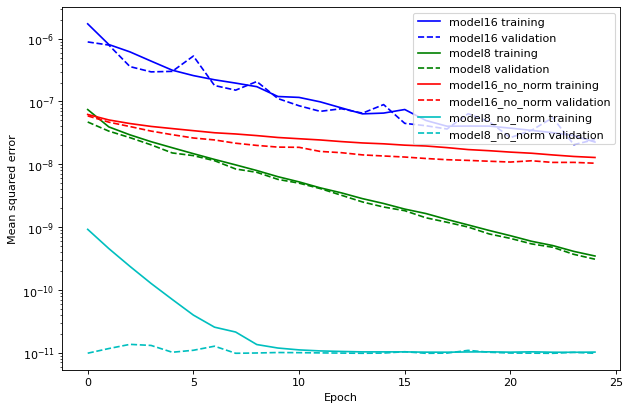

In [ ]:
# Plot
plot_mult_models(models)

## 1.4 Derived &rarr; dependent variables